# build-cat-ccam_noresm2-mm_historical_aus-10i_12km

In [1]:
import glob
import pathlib
import traceback
from datetime import datetime

import xarray as xr

#from ecgtools import Builder
#from ecgtools.builder import INVALID_ASSET, TRACEBACK

from matplotlib import pyplot as plt

In [2]:
from dask.distributed import Client
client = Client()
client

/g/data/v14/tm4888/miniconda3/envs/intake-stable/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42777 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/42777/status,
Dashboard: /proxy/42777/status,Workers: 2
Total threads: 2,Total memory: 9.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44611,Workers: 2
Dashboard: /proxy/42777/status,Total threads: 2
Started: Just now,Total memory: 9.00 GiB
Comm: tcp://127.0.0.1:45967,Total threads: 1
Dashboard: /proxy/41583/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:43119,


# build the catalogue

In [ ]:
root = '/g/data/xv83/mxt599/ccam_noresm2-mm_historical_aus-10i_12km/drs_cordex/CORDEX/output/AUS-10i/CSIRO/NCC-NorESM2-MM/historical/r1i1p1f1/CSIRO-CCAM-2203/v1/'

In [ ]:
files = sorted(glob.glob(root+'*/*/*'))
len(files)

In [ ]:
files[0]

In [ ]:
ds = xr.open_mfdataset(files[0:11],parallel=True)
ds

In [ ]:
path = pathlib.Path(files[0])
path.stem.split('_')

# NOTES from Marcus chat

## use this as an error check?

In [ ]:
variable_list = [var for var in ds if 'long_name' in ds[var].attrs]
variable_list

In [ ]:
split = path.stem.split('_')

In [ ]:
split[0]

# do we really need to open all the files?  Given variable name is in the filename?

In [ ]:
def parse_CCAM(file):
    """CCAM data stored in"""
    file = pathlib.Path(file)
    info = {}

    try:
        stem = file.stem
        split = stem.split('_')
        variable = split[0]
        domain = split[1]
        host_GCM = split[2]
        run_type = split[3]
        host_ensemble = split[4]
        downscale_model = split[5]
        downscale_version = split[6]
        period = split[7]
        if period == '1hr':
            time_period = 'hourly'
        elif period == '6hr':
            time_period = 'six_hourly'
        elif period == 'day':
            time_period = 'daily'
        elif period == 'mon':
            time_period = 'monthly'
        else:
            time_period = 'fixed'    

        
        info = {
            'variable': variable,
            'domain': domain,
            'host_GCM':host_GCM,
            'run_type':run_type,
            'host_ensemble':host_ensemble,
            'downscale_model':downscale_model,
            'downscale_version':downscale_version,
            'period': period,
            'time_period': time_period,
            'path': str(file),
        }
        return info
    
    except Exception:
        return {INVALID_ASSET: file, TRACEBACK: traceback.format_exc()}

In [ ]:
parse_CCAM(files[0])

# setup builder object

In [ ]:
root2 = '/g/data/xv83/mxt599/ccam_noresm2-mm_historical_aus-10i_12km/drs_cordex/CORDEX/output/AUS-10i/CSIRO/NCC-NorESM2-MM/historical/r1i1p1f1/CSIRO-CCAM-2203/v1'

In [ ]:
%%time
b = Builder([root2],depth=2)

In [ ]:
b

In [ ]:
%%time
b.build(parsing_func = parse_CCAM)

In [ ]:
b.df

In [ ]:
dir(b)

In [ ]:
b.invalid_assets['INVALID_ASSET'].values

## example from docs

In [ ]:
b.save(
    # File path - could save as .csv (uncompressed csv) or .csv.gz (compressed csv)
    name = "/intake-catalogues/test-CCAM-catalogue",
    # Column name including filepath
    path_column_name='path',
    # Column name including variables
    variable_column_name='variable',
    # Data file format - could be netcdf or zarr (in this case, netcdf)
    data_format="netcdf",
    # Which attributes to groupby when reading in variables using intake-esm
    groupby_attrs=["domain", "host_GCM", "run_type","host_ensemble","downscale_model","downscale_version","period"],
    # Aggregations which are fed into xarray when reading in data using intake
    aggregations=[
        {
            "type": "join_existing",
            "attribute_name": "date",
            "options": {"dim": "time", "coords": "minimal", "compat": "override"},
        }
    ],
)

NameError: name 'b' is not defined

# Can I querry the catalogue? YES!

In [3]:
import intake

### SICK OF ALL THESE WARNINGS?

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
data_catalog = intake.open_esm_datastore('/g/data/v14/tm4888/code/ACS/data-catalogue/catalogues/test-CCAM-catalogue.json')
data_catalog

,unique
variable,176
domain,1
host_GCM,1
run_type,1
host_ensemble,1
downscale_model,1
downscale_version,1
period,4
time_period,4
path,32960


In [6]:
data_catalog.df

,variable,domain,host_GCM,run_type,host_ensemble,downscale_model,downscale_version,period,time_period,path
0,CAPE,AUS-10i,NCC-NorESM2-MM,historical,r1i1p1f1,CSIRO-CCAM-2203,v1,1hr,hourly,/g/data/xv83/mxt599/ccam_noresm2-mm_historical...
1,CAPE,AUS-10i,NCC-NorESM2-MM,historical,r1i1p1f1,CSIRO-CCAM-2203,v1,1hr,hourly,/g/data/xv83/mxt599/ccam_noresm2-mm_historical...
2,CAPE,AUS-10i,NCC-NorESM2-MM,historical,r1i1p1f1,CSIRO-CCAM-2203,v1,1hr,hourly,/g/data/xv83/mxt599/ccam_noresm2-mm_historical...
3,CAPE,AUS-10i,NCC-NorESM2-MM,historical,r1i1p1f1,CSIRO-CCAM-2203,v1,1hr,hourly,/g/data/xv83/mxt599/ccam_noresm2-mm_historical...
4,CAPE,AUS-10i,NCC-NorESM2-MM,historical,r1i1p1f1,CSIRO-CCAM-2203,v1,1hr,hourly,/g/data/xv83/mxt599/ccam_noresm2-mm_historical...
...,...,...,...,...,...,...,...,...,...,...
32955,zmla,AUS-10i,NCC-NorESM2-MM,historical,r1i1p1f1,CSIRO-CCAM-2203,v1,mon,monthly,/g/data/xv83/mxt599/ccam_noresm2-mm_historical...
32956,zmla,AUS-10i,NCC-NorESM2-MM,historical,r1i1p1f1,CSIRO-CCAM-2203,v1,mon,monthly,/g/data/xv83/mxt599/ccam_noresm2-mm_historical...
32957,zmla,AUS-10i,NCC-NorESM2-MM,historical,r1i1p1f1,CSIRO-CCAM-2203,v1,mon,monthly,/g/data/xv83/mxt599/ccam_noresm2-mm_historical...
32958,zmla,AUS-10i,NCC-NorESM2-MM,historical,r1i1p1f1,CSIRO-CCAM-2203,v1,mon,monthly,/g/data/xv83/mxt599/ccam_noresm2-mm_historical...


In [7]:
data_catalog.df.variable.unique()

array(['CAPE', 'CIN', 'clh', 'clivi', 'cll', 'clm', 'clt', 'clwvi',
       'evspsbl', 'evspsblpot', 'hfls', 'hfss', 'hurs', 'huss', 'mrfsos',
       'mrsos', 'pr', 'prc', 'prsn', 'prw', 'ps', 'psl', 'rlds', 'rlus',
       'rlut', 'rsds', 'rsdsdir', 'rsdt', 'rsus', 'rsut', 'sfcWind',
       'tas', 'ts', 'ua100m', 'ua150m', 'ua200m', 'ua250m', 'ua300m',
       'ua50m', 'uas', 'va100m', 'va150m', 'va200m', 'va250m', 'va300m',
       'va50m', 'vas', 'zmla', 'hus10', 'hus100', 'hus1000', 'hus150',
       'hus20', 'hus200', 'hus250', 'hus30', 'hus300', 'hus400', 'hus50',
       'hus500', 'hus600', 'hus70', 'hus700', 'hus850', 'hus925', 'mrfso',
       'mrfsol', 'mrro', 'mrros', 'mrso', 'mrsol', 'snc', 'snd', 'snm',
       'snw', 'ta10', 'ta100', 'ta1000', 'ta150', 'ta20', 'ta200',
       'ta250', 'ta30', 'ta300', 'ta400', 'ta50', 'ta500', 'ta600',
       'ta70', 'ta700', 'ta850', 'ta925', 'tauu', 'tauv', 'tsl', 'ua10',
       'ua100', 'ua1000', 'ua150', 'ua20', 'ua200', 'ua250', 'ua30',
    

In [8]:
data_catalog.df.period.unique()

array(['1hr', '6hr', 'day', 'mon'], dtype=object)

In [9]:
search1 = data_catalog.search(variable=['tas'],period='mon')
search1

,unique
variable,1
domain,1
host_GCM,1
run_type,1
host_ensemble,1
downscale_model,1
downscale_version,1
period,1
time_period,1
path,64


In [10]:
search1.df

,variable,domain,host_GCM,run_type,host_ensemble,downscale_model,downscale_version,period,time_period,path
0,tas,AUS-10i,NCC-NorESM2-MM,historical,r1i1p1f1,CSIRO-CCAM-2203,v1,mon,monthly,/g/data/xv83/mxt599/ccam_noresm2-mm_historical...
1,tas,AUS-10i,NCC-NorESM2-MM,historical,r1i1p1f1,CSIRO-CCAM-2203,v1,mon,monthly,/g/data/xv83/mxt599/ccam_noresm2-mm_historical...
2,tas,AUS-10i,NCC-NorESM2-MM,historical,r1i1p1f1,CSIRO-CCAM-2203,v1,mon,monthly,/g/data/xv83/mxt599/ccam_noresm2-mm_historical...
3,tas,AUS-10i,NCC-NorESM2-MM,historical,r1i1p1f1,CSIRO-CCAM-2203,v1,mon,monthly,/g/data/xv83/mxt599/ccam_noresm2-mm_historical...
4,tas,AUS-10i,NCC-NorESM2-MM,historical,r1i1p1f1,CSIRO-CCAM-2203,v1,mon,monthly,/g/data/xv83/mxt599/ccam_noresm2-mm_historical...
...,...,...,...,...,...,...,...,...,...,...
59,tas,AUS-10i,NCC-NorESM2-MM,historical,r1i1p1f1,CSIRO-CCAM-2203,v1,mon,monthly,/g/data/xv83/mxt599/ccam_noresm2-mm_historical...
60,tas,AUS-10i,NCC-NorESM2-MM,historical,r1i1p1f1,CSIRO-CCAM-2203,v1,mon,monthly,/g/data/xv83/mxt599/ccam_noresm2-mm_historical...
61,tas,AUS-10i,NCC-NorESM2-MM,historical,r1i1p1f1,CSIRO-CCAM-2203,v1,mon,monthly,/g/data/xv83/mxt599/ccam_noresm2-mm_historical...
62,tas,AUS-10i,NCC-NorESM2-MM,historical,r1i1p1f1,CSIRO-CCAM-2203,v1,mon,monthly,/g/data/xv83/mxt599/ccam_noresm2-mm_historical...


In [11]:
%%time
dsets = search1.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'domain.host_GCM.run_type.host_ensemble.downscale_model.downscale_version.period'


CPU times: user 2.57 s, sys: 805 ms, total: 3.38 s
Wall time: 14 s


In [12]:
dsets.keys()

dict_keys(['AUS-10i.NCC-NorESM2-MM.historical.r1i1p1f1.CSIRO-CCAM-2203.v1.mon'])

In [13]:
search_DS = dsets['AUS-10i.NCC-NorESM2-MM.historical.r1i1p1f1.CSIRO-CCAM-2203.v1.mon']

In [14]:
search_DS

<xarray.Dataset>
Dimensions:   (time: 768, lat: 611, lon: 928, bnds: 2)
Coordinates:
  * time      (time) object 1951-01-15 12:00:00 ... 2014-12-15 12:00:00
    lat_bnds  (lat, bnds) float32 dask.array<chunksize=(611, 2), meta=np.ndarray>
    lon_bnds  (lon, bnds) float32 dask.array<chunksize=(928, 2), meta=np.ndarray>
  * lon       (lon) float64 89.3 89.4 89.5 89.6 89.7 ... 181.7 181.8 181.9 182.0
  * lat       (lat) float64 -52.3 -52.2 -52.1 -52.0 -51.9 ... 8.4 8.5 8.6 8.7
Dimensions without coordinates: bnds
Data variables:
    tas       (time, lat, lon) float32 dask.array<chunksize=(12, 611, 928), meta=np.ndarray>
Attributes: (12/29)
    axiom_version:                       0.1.0
    axiom_schemas_version:               0.1.0
    axiom_schema:                        CORDEX
    contact:                             Marcus Thatcher (Marcus.Thatcher@csi...
    Conventions:                         CF-1.7
    CORDEX_domain:                       AUS-10i
    ...                                  ...
    intake_esm_attrs:downscale_model:    CSIRO-CCAM-2203
    intake_esm_attrs:downscale_version:  v1
    intake_esm_attrs:period:             mon
    intake_esm_attrs:time_period:        monthly
    intake_esm_attrs:_data_format_:      netcdf
    intake_esm_dataset_key:              AUS-10i.NCC-NorESM2-MM.historical.r1...

In [15]:
mean_tas = search_DS.tas.mean(dim='time')
mean_tas

<xarray.DataArray 'tas' (lat: 611, lon: 928)>
dask.array<mean_agg-aggregate, shape=(611, 928), dtype=float32, chunksize=(611, 928), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 89.3 89.4 89.5 89.6 89.7 ... 181.7 181.8 181.9 182.0
  * lat      (lat) float64 -52.3 -52.2 -52.1 -52.0 -51.9 ... 8.3 8.4 8.5 8.6 8.7

In [16]:
%%time
mean_tas = mean_tas.compute()

CPU times: user 615 ms, sys: 129 ms, total: 744 ms
Wall time: 5.44 s


In [18]:
mean_temp = mean_tas - 273.15

Text(0.5, 1.0, 'Mean Near-Surface Air Temperature in degrees C for \n AUS-10i.NCC-NorESM2-MM.historical.r1i1p1f1.CSIRO-CCAM-2203.v1.mon')

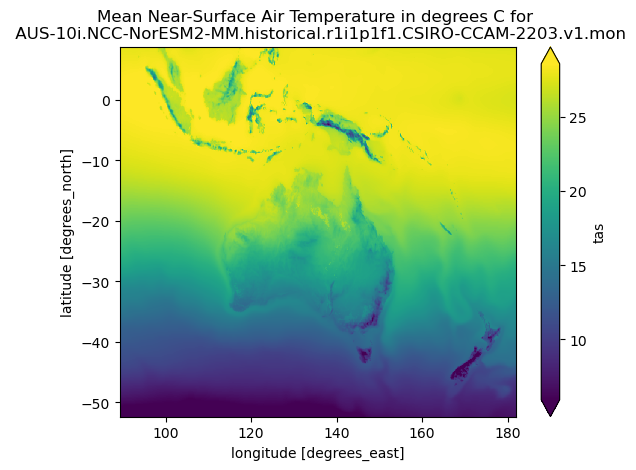

In [20]:
mean_temp.plot(robust=True)
plt.title('Mean Near-Surface Air Temperature in degrees C for \n AUS-10i.NCC-NorESM2-MM.historical.r1i1p1f1.CSIRO-CCAM-2203.v1.mon')

# seasonal climatology

In [21]:
tas_season_mean = search_DS.tas.groupby('time.season').mean('time')

In [22]:
tas_season_mean

<xarray.DataArray 'tas' (season: 4, lat: 611, lon: 928)>
dask.array<stack, shape=(4, 611, 928), dtype=float32, chunksize=(1, 611, 928), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 89.3 89.4 89.5 89.6 89.7 ... 181.7 181.8 181.9 182.0
  * lat      (lat) float64 -52.3 -52.2 -52.1 -52.0 -51.9 ... 8.3 8.4 8.5 8.6 8.7
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Attributes:
    long_name:      Near-Surface Air Temperature
    standard_name:  air_temperature
    units:          K
    cell_methods:   time: mean

In [23]:
temp_season_mean = tas_season_mean-273.15

In [24]:
temp_season_mean

<xarray.DataArray 'tas' (season: 4, lat: 611, lon: 928)>
dask.array<sub, shape=(4, 611, 928), dtype=float32, chunksize=(1, 611, 928), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 89.3 89.4 89.5 89.6 89.7 ... 181.7 181.8 181.9 182.0
  * lat      (lat) float64 -52.3 -52.2 -52.1 -52.0 -51.9 ... 8.3 8.4 8.5 8.6 8.7
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'

Text(0.5, 1.0, 'Winter(JJA) Near-Surface Air Temperature in degrees C for \n AUS-10i.NCC-NorESM2-MM.historical.r1i1p1f1.CSIRO-CCAM-2203.v1.mon')

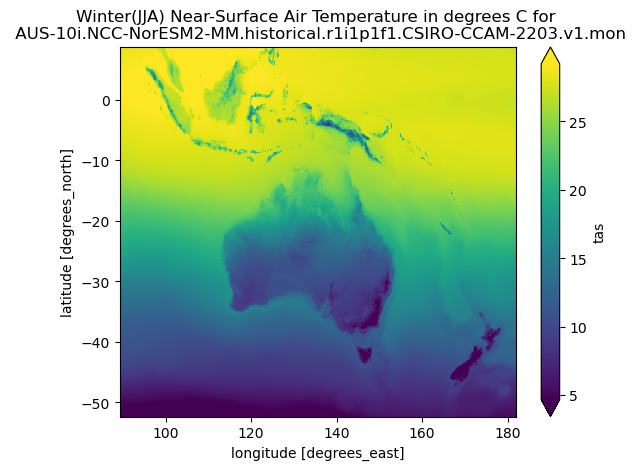

In [29]:
temp_season_mean.sel(season='JJA').plot(robust=True)
plt.title('Winter(JJA) Near-Surface Air Temperature in degrees C for \n AUS-10i.NCC-NorESM2-MM.historical.r1i1p1f1.CSIRO-CCAM-2203.v1.mon')

In [30]:
client.close()